In [159]:
import pandas as pd
import matplotlib.pyplot as plt

In [160]:
df = pd.read_csv("Data/monthly-robberies.csv", index_col=0, parse_dates=True)
df

,Robberies
Month,
1966-01-01,41
1966-02-01,39
1966-03-01,50
1966-04-01,40
1966-05-01,43
...,...
1975-06-01,316
1975-07-01,398
1975-08-01,394


In [161]:
df.describe()

,Robberies
count,118.000000
mean,196.288136
std,128.043602
min,29.000000
25%,85.500000
50%,166.000000
75%,296.750000
max,500.000000


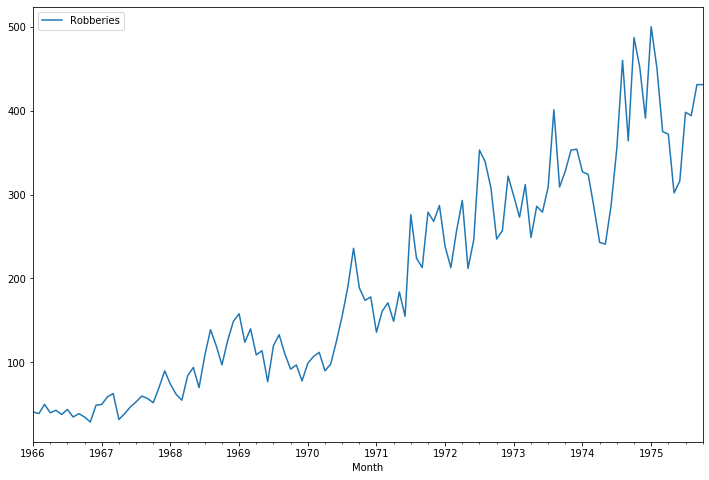

In [162]:
df.plot(figsize=(12,8));

* final year of data will be used to validate the model. The code below will load the dataset as a Pandas Series and split into two, one for model development and the other for validation.

    * dataset.csv: Observations from January 1966 to October 1974 (106 observations)
    * validation.csv: Observations from November 1974 to October 1975 (12 observations)
   
The validation dataset is 10% of the original dataset.

In [163]:
data = df[:-12]
data

,Robberies
Month,
1966-01-01,41
1966-02-01,39
1966-03-01,50
1966-04-01,40
1966-05-01,43
...,...
1974-06-01,287
1974-07-01,355
1974-08-01,460


In [164]:
validation = df[-12:]
print(validation.info())
validation

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 1974-11-01 to 1975-10-01
Data columns (total 1 columns):
Robberies    12 non-null int64
dtypes: int64(1)
memory usage: 192.0 bytes
None


,Robberies
Month,
1974-11-01,452
1974-12-01,391
1975-01-01,500
1975-02-01,451
1975-03-01,375
1975-04-01,372
1975-05-01,302
1975-06-01,316
1975-07-01,398


### Test Strategy

Candidate models will be evaluated using walk-forward validation. The walk-forward validation will work as follows:

1. The first 50% of the dataset will be held back to train the model.
2. The remaining 50% of the dataset will be iterated and test the model.
3. A one-step prediction made.

In [165]:
X =data

train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

### Persistence

* The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction
for the observation at the next time step. 

In [166]:
from sklearn.metrics import mean_squared_error
from math import sqrt

test['pred'] = test['Robberies'].shift()

#get first prediction from the last observation of train dataset
test['pred'][0] = train['Robberies'][-1]

test['error'] = test['Robberies'] - test['pred']


# report performance
rmse = sqrt(mean_squared_error(test['Robberies'], test['pred']))
print('RMSE: %.3f' % rmse)

RMSE: 51.844


In [167]:
test.head()

,Robberies,pred,error
Month,,,
1970-06-01,125,98.0,27.0
1970-07-01,155,125.0,30.0
1970-08-01,190,155.0,35.0
1970-09-01,236,190.0,46.0
1970-10-01,189,236.0,-47.0


* We now have a baseline prediction method and performance; now we can start digging into
our data.

In [168]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_test(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [169]:
dickey_fuller_test(data)

Results of Dickey-Fuller Test:
Test Statistic                  0.797485
p-value                         0.991595
#Lags Used                     12.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


* We can't reject the null hypothesis. It means that the process has  unit root and time series isn't stationary. Let's take a difference and test it again.

In [170]:
data_diff = data.diff().dropna()

dickey_fuller_test(data_diff)

Results of Dickey-Fuller Test:
Test Statistic                 -3.980946
p-value                         0.001514
#Lags Used                     11.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


* We can reject the null hypothesis. It means that the process has no unit root, and in turn that the 1-lag differenced time series is stationary or does not have time-dependent structure.

* This suggests that at least one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1. The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. The example below creates ACF and PACF plots for the series.

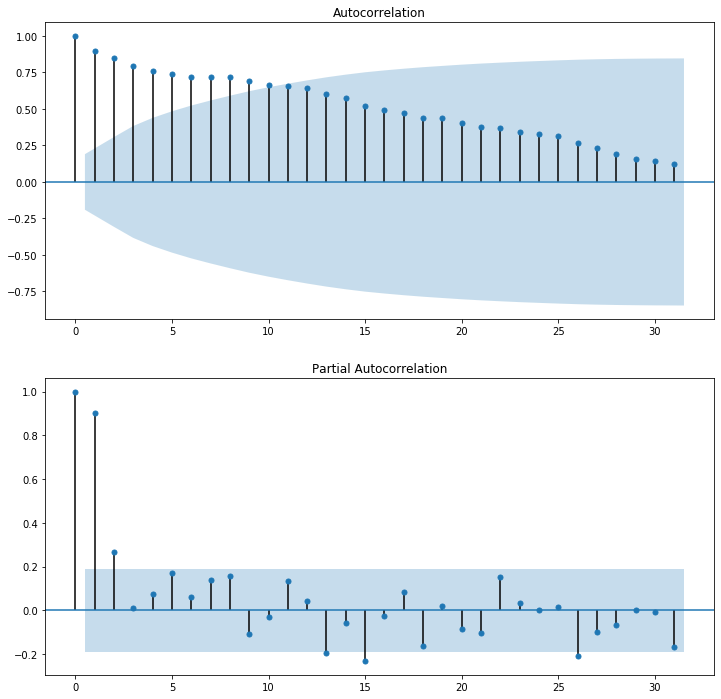

In [171]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1,figsize=(12, 12))

plot_acf(data, lags=31, ax=ax[0])
plot_pacf(data, lags=31, ax=ax[1])

plt.show()

* Let's try ARIMA (2,1,0)

In [172]:
data.shape

(106, 1)

In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 1966-01-01 to 1974-10-01
Data columns (total 1 columns):
Robberies    106 non-null int64
dtypes: int64(1)
memory usage: 1.7 KB


In [174]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data, order=(2,1,0))

# Make predictions for last 53 values
results = model.fit()

# Make in-sample prediction
forecast = results.get_prediction(start=-53)

In [175]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

rmse = sqrt(mean_squared_error(test.Robberies, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 49.421


In [176]:
# Assign residuals to variable
residuals = results.resid
mae1 = np.mean(np.abs(residuals))
mae1

26.709256721276933

In [177]:
mae2=np.mean(np.abs(test.Robberies-forecast.predicted_mean))
mae2

38.800086991827754

In [178]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Robberies   No. Observations:                  106
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -528.803
Date:                Mon, 27 Apr 2020   AIC                           1063.607
Time:                        19:14:14   BIC                           1071.569
Sample:                    01-01-1966   HQIC                          1066.833
                         - 10-01-1974                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3025      0.075     -4.024      0.000      -0.450      -0.155
ar.L2         -0.1711      0.082     -2.085      0.037      -0.332      -0.010
sigma2      1384.7130    139.475      9.928      0.000    1111.348    1658.078
===================================================================================
Ljung-Box (Q):                       52.11   Jarque-Bera (JB):                32.26
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):              11.46   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Prob(Q) - p-value for null hypothesis that residuals are uncorrelated
* Prob(JB) - p-value for null hypothesis that residuals are normal

residuals are uncorrelated but not normally distributed!!!

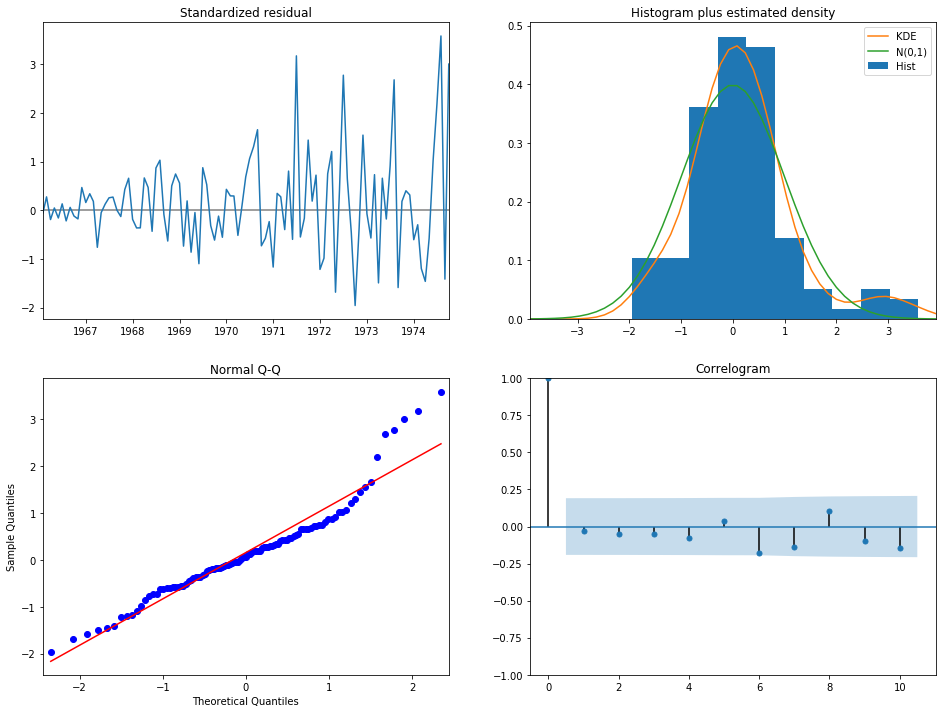

In [179]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(16,12))
plt.show()

* ARIMA (0,1,2) from the book

In [180]:
model = SARIMAX(data, order=(0,1,2), trend='c')

# Make predictions for last 53 values
results = model.fit()

# Make in-sample prediction
forecast = results.get_prediction(start=-53)

In [181]:
rmse = sqrt(mean_squared_error(test.Robberies, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 47.445


In [182]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Robberies   No. Observations:                  106
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -526.103
Date:                Mon, 27 Apr 2020   AIC                           1060.207
Time:                        19:14:25   BIC                           1070.823
Sample:                    01-01-1966   HQIC                          1064.509
                         - 10-01-1974                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4813      1.205      2.888      0.004       1.119       5.844
ma.L1         -0.4365      0.106     -4.109      0.000      -0.645      -0.228
ma.L2         -0.2822      0.072     -3.909      0.000      -0.424      -0.141
sigma2      1309.2081    140.966      9.287      0.000    1032.920    1585.496
===================================================================================
Ljung-Box (Q):                       56.20   Jarque-Bera (JB):                65.93
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):              11.82   Skew:                             1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

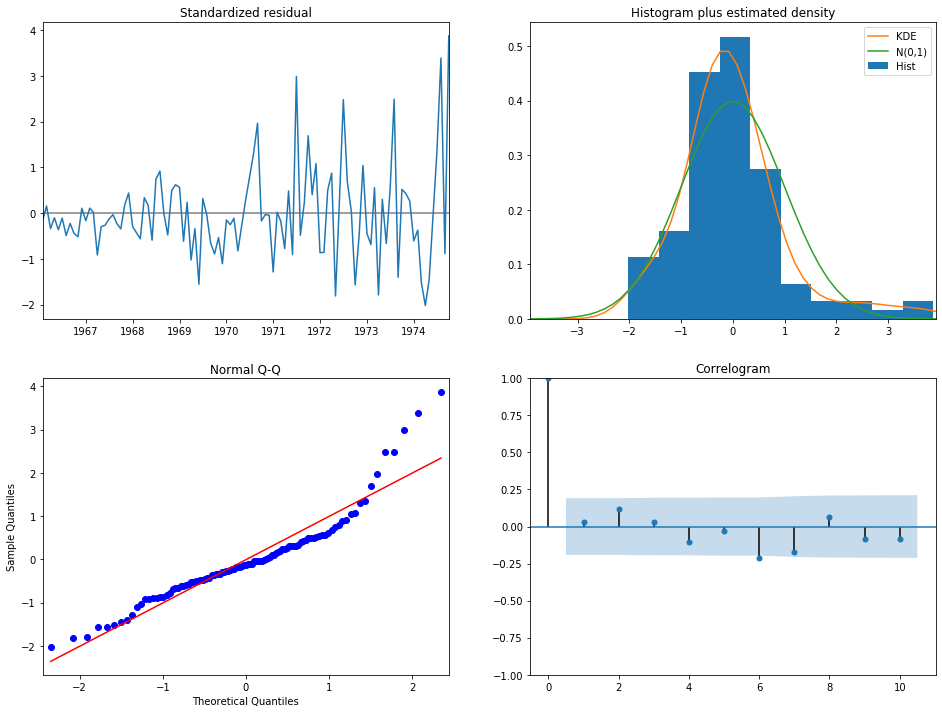

In [183]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(16,12))
plt.show()

### Searching over AIC and BIC

In [184]:
import warnings
warnings.filterwarnings("ignore")

aicVal = []

# Loop over AR order
for p in range(15):
    
    # Loop over MA order
    for q in range(15):
    
        # Fit model
        model = SARIMAX(data, order=(p,1,q))
        results = model.fit()
        
        aicVal.append([p, q, results.aic, results.bic])


In [185]:
opt = pd.DataFrame(aicVal, columns=["p", "q", "AIC", "BIC"])
opt.sort_values("AIC")

,p,q,AIC,BIC
185,12,5,1057.936956,1105.708243
196,13,1,1058.002368,1097.811773
182,12,2,1058.016326,1097.825731
198,13,3,1058.537505,1103.654831
210,14,0,1058.562474,1098.371880
...,...,...,...,...
163,10,13,1080.103124,1143.798172
147,9,12,1080.409743,1138.796870
175,11,10,1080.459296,1138.846423
207,13,12,1080.557198,1149.560167


* Let's try ARIMA(12,1,5)

In [186]:
model = SARIMAX(data, order=(12,1,5), trend='c')

# Make predictions for last 53 values
results = model.fit()

# Make in-sample prediction
forecast = results.get_prediction(start=-53)

In [187]:
rmse = sqrt(mean_squared_error(test.Robberies, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 37.305


In [188]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Robberies   No. Observations:                  106
Model:              SARIMAX(12, 1, 5)   Log Likelihood                -508.917
Date:                Mon, 27 Apr 2020   AIC                           1055.835
Time:                        21:07:14   BIC                           1106.260
Sample:                    01-01-1966   HQIC                          1076.268
                         - 10-01-1974                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.9805     16.974      0.765      0.444     -20.289      46.250
ar.L1         -0.4096      0.509     -0.804      0.421      -1.408       0.589
ar.L2         -0.1960      0.512     -0.383      0.702      -1.200       0.808
ar.L3         -0.3180      0.356     -0.893      0.372      -1.016       0.380
ar.L4         -0.7041      0.386     -1.826      0.068      -1.460       0.052
ar.L5          0.1884      0.579      0.326      0.745      -0.946       1.323
ar.L6         -0.2440      0.370     -0.659      0.510      -0.970       0.482
ar.L7         -0.3885      0.413     -0.941      0.347      -1.197       0.420
ar.L8         -0.1384      0.459     -0.301      0.763      -1.038       0.761
ar.L9         -0.2021      0.374     -0.541      0.589      -0.934       0.530
ar.L10        -0.3998      0.335     -1.194      0.232      -1.056       0.256
ar.L11        -0.1350      0.416     -0.324      0.746      -0.951       0.680
ar.L12         0.2908      0.314      0.925      0.355      -0.325       0.907
ma.L1         -0.0271      0.654     -0.041      0.967      -1.308       1.254
ma.L2         -0.0612      0.307     -0.199      0.842      -0.663       0.541
ma.L3          0.1299      0.214      0.608      0.543      -0.289       0.549
ma.L4          0.4260      0.471      0.905      0.365      -0.496       1.348
ma.L5         -0.6658      0.385     -1.730      0.084      -1.420       0.088
sigma2       908.2226    355.979      2.551      0.011     210.517    1605.928
===================================================================================
Ljung-Box (Q):                       20.46   Jarque-Bera (JB):                12.09
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.46   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

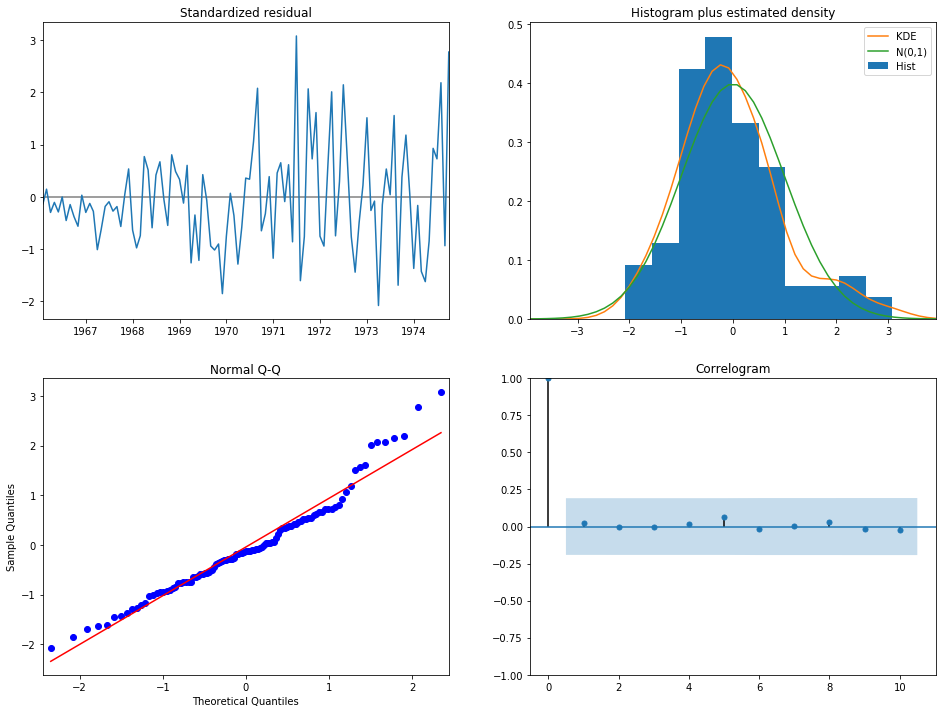

In [189]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(16,12))
plt.show()

* still not normally distributed!!!

In [190]:
data_diff=data.diff().dropna()


In [191]:
import pmdarima as pm


results = pm.auto_arima(data, # data
                        
                        start_p=0, # initial guess for p
                        start_q=0, # initial guess for q
                        
                        seasonal=True, # is the time series seasonal
                        m=12, # the seasonal period
                        D=1, # seasonal difference order
                        start_P=0, # initial guess for P
                        start_Q=0, # initial guess for Q
                        max_P=2, # max value of P to test
                        max_Q=2, # max value of Q to test
                       )

In [192]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  106
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood                -467.396
Date:                              Mon, 27 Apr 2020   AIC                            948.793
Time:                                      21:08:23   BIC                            966.596
Sample:                                           0   HQIC                           955.984
                                              - 106                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.5792     11.150      1.756      0.079      -2.275      41.433
ar.L1          0.4190      0.106      3.955      0.000       0.211       0.627
ar.L2          0.2650      0.112      2.360      0.018       0.045       0.485
ar.S.L12      -0.2233      0.302     -0.739      0.460      -0.816       0.369
ar.S.L24      -0.2803      0.149     -1.885      0.059      -0.572       0.011
ma.S.L12      -0.3911      0.314     -1.245      0.213      -1.007       0.224
sigma2      1123.5888    189.186      5.939      0.000     752.791    1494.387
===================================================================================
Ljung-Box (Q):                       38.99   Jarque-Bera (JB):                 7.60
Prob(Q):                              0.52   Prob(JB):                         0.02
Heteroskedasticity (H):               5.65   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

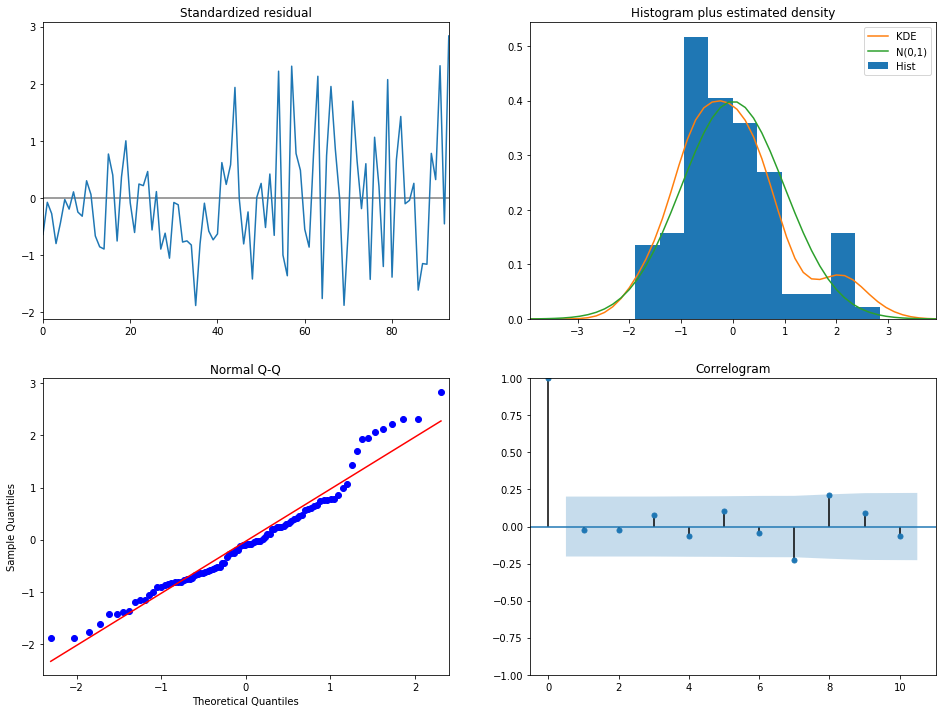

In [193]:
results.plot_diagnostics(figsize=(16,12));

In [194]:
# Instantiate model
model = SARIMAX(data, order=(2,0,0), seasonal_order=(2,1,1,12))

# Fit model
results = model.fit()

In [195]:
# Make in-sample prediction
forecast = results.get_prediction(start=-53)

In [196]:
rmse = sqrt(mean_squared_error(test.Robberies, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 43.810


### boxcox transformation

In [197]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from math import exp
from math import log

In [198]:
data_transformed, lam = boxcox(data.Robberies)

In [199]:
model = SARIMAX(data_transformed, order=(12,1,5), trend='c')

results = model.fit()

# Make out-of-sample prediction
forecast = results.get_prediction(start=-53)

In [200]:
prediction =inv_boxcox(forecast.predicted_mean, lam)

In [201]:
rmse = sqrt(mean_squared_error(test.Robberies, prediction))
print('RMSE: %.3f' % rmse)

RMSE: 39.595


In [202]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  106
Model:              SARIMAX(12, 1, 5)   Log Likelihood                -102.533
Date:                Mon, 27 Apr 2020   AIC                            243.065
Time:                        21:08:33   BIC                            293.491
Sample:                             0   HQIC                           263.499
                                - 106                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2003      3.611      0.055      0.956      -6.877       7.277
ar.L1         -0.3748      5.722     -0.065      0.948     -11.591      10.841
ar.L2         -0.0226      6.078     -0.004      0.997     -11.935      11.890
ar.L3         -0.1097      4.251     -0.026      0.979      -8.442       8.223
ar.L4         -0.6059      3.460     -0.175      0.861      -7.388       6.176
ar.L5          0.1968      5.780      0.034      0.973     -11.133      11.526
ar.L6         -0.1497      2.909     -0.051      0.959      -5.851       5.551
ar.L7         -0.2381      2.884     -0.083      0.934      -5.890       5.414
ar.L8         -0.0274      3.349     -0.008      0.993      -6.591       6.536
ar.L9         -0.0972      2.456     -0.040      0.968      -4.910       4.716
ar.L10        -0.2737      2.246     -0.122      0.903      -4.676       4.129
ar.L11        -0.0344      3.121     -0.011      0.991      -6.151       6.082
ar.L12         0.2662      2.296      0.116      0.908      -4.234       4.767
ma.L1          0.0331      5.754      0.006      0.995     -11.245      11.311
ma.L2         -0.2705      4.127     -0.066      0.948      -8.360       7.819
ma.L3         -0.0455      1.229     -0.037      0.970      -2.454       2.363
ma.L4          0.5055      0.590      0.857      0.391      -0.651       1.662
ma.L5         -0.4139      3.232     -0.128      0.898      -6.748       5.920
sigma2         0.3986      0.086      4.616      0.000       0.229       0.568
===================================================================================
Ljung-Box (Q):                       21.34   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.99   Prob(JB):                         0.90
Heteroskedasticity (H):               0.86   Skew:                             0.05
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

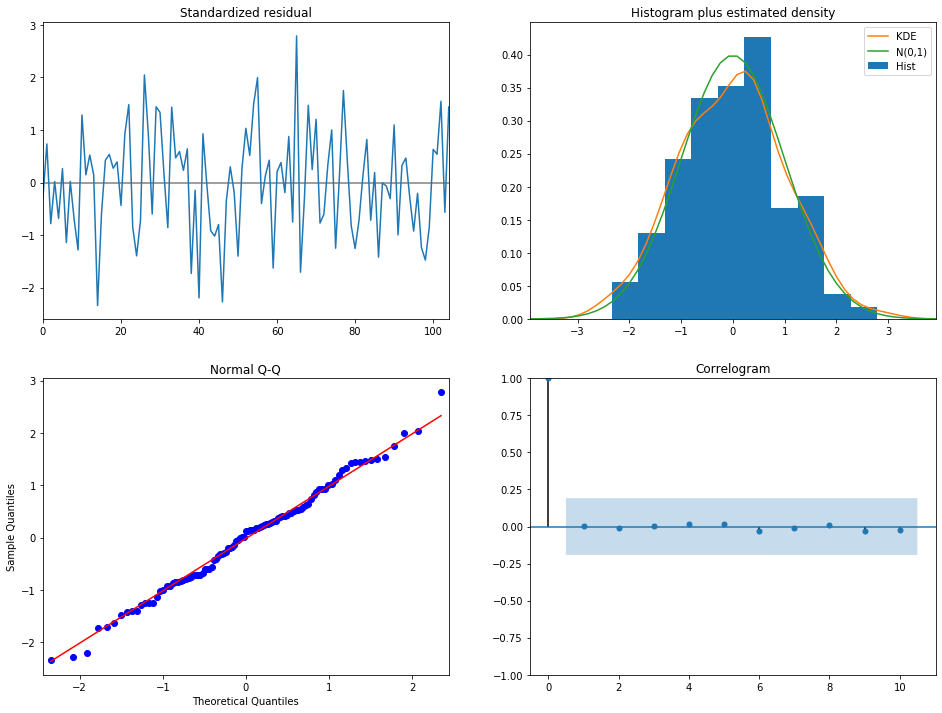

In [203]:
results.plot_diagnostics(figsize=(16,12));

### Forecasting out of sample

#### ARIMA (12,1,5)

In [204]:
model = SARIMAX(data, order=(12,1,5), trend='c')

results = model.fit()

# Make out-of-sample prediction
forecast = results.get_forecast(steps=12)

In [205]:
rmse = sqrt(mean_squared_error(validation.Robberies, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 36.988


#### ARIMA (2,1,0)

In [206]:
model = SARIMAX(data, order=(2,1,0), trend='c')

results = model.fit()

# Make out-of-sample prediction
forecast = results.get_forecast(steps=12)

In [207]:
rmse = sqrt(mean_squared_error(validation.Robberies, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 102.676


#### ARIMA (0,1,2)

In [208]:
model = SARIMAX(data, order=(0,1,2), trend='c')

results = model.fit()

# Make out-of-sample prediction
forecast = results.get_forecast(steps=12)

In [209]:
rmse = sqrt(mean_squared_error(validation.Robberies, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 59.042


#### SARIMA (2,0,0) (2,1,1,12)

In [210]:
# Instantiate model
model = SARIMAX(data, order=(2,0,0), seasonal_order=(2,1,1,12))

results = model.fit()

# Make out-of-sample prediction
forecast = results.get_forecast(steps=12)

In [211]:
rmse = sqrt(mean_squared_error(validation.Robberies, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 65.766


#### ARIMA (12,1,5) with boxcox transformation

In [212]:
# Instantiate model
model = SARIMAX(data_transformed, order=(12,1,5))

results = model.fit()

# Make out-of-sample prediction
forecast_tr = results.get_forecast(steps=12)

In [213]:
forecast_normal = inv_boxcox(forecast_tr.predicted_mean, lam)

In [214]:
rmse = sqrt(mean_squared_error(validation.Robberies, forecast_normal))
print('RMSE: %.3f' % rmse)

RMSE: 55.103


#### ARIMA (0,1,2) with boxcox transformation

In [215]:
# Instantiate model
model = SARIMAX(data_transformed, order=(0,1,2))

results = model.fit()

# Make out-of-sample prediction
forecast_tr = results.get_forecast(steps=12)

In [216]:
forecast_normal = inv_boxcox(forecast_tr.predicted_mean, lam)

In [217]:
rmse = sqrt(mean_squared_error(validation.Robberies, forecast_normal))
print('RMSE: %.3f' % rmse)

RMSE: 61.320


* ARIMA(12,1,5) gives the best result of all methods above. 

### Exogenous Variables 

In [218]:
df.head()

,Robberies
Month,
1966-01-01,41
1966-02-01,39
1966-03-01,50
1966-04-01,40
1966-05-01,43


In [219]:
df['month'] = df.index.month_name()
df.head()

,Robberies,month
Month,,
1966-01-01,41,January
1966-02-01,39,February
1966-03-01,50,March
1966-04-01,40,April
1966-05-01,43,May


In [220]:
df_with_dummy = pd.get_dummies(data=df, columns=['month'], prefix='', prefix_sep='')
df_with_dummy

,Robberies,April,August,December,February,January,July,June,March,May,November,October,September
Month,,,,,,,,,,,,,
1966-01-01,41,0,0,0,0,1,0,0,0,0,0,0,0
1966-02-01,39,0,0,0,1,0,0,0,0,0,0,0,0
1966-03-01,50,0,0,0,0,0,0,0,1,0,0,0,0
1966-04-01,40,1,0,0,0,0,0,0,0,0,0,0,0
1966-05-01,43,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975-06-01,316,0,0,0,0,0,0,1,0,0,0,0,0
1975-07-01,398,0,0,0,0,0,1,0,0,0,0,0,0
1975-08-01,394,0,1,0,0,0,0,0,0,0,0,0,0


In [221]:
df_with_dummy_columns = df_with_dummy.drop('Robberies', axis=1).columns.values
df_with_dummy_columns

array(['April', 'August', 'December', 'February', 'January', 'July',
       'June', 'March', 'May', 'November', 'October', 'September'],
      dtype=object)

In [222]:
df_with_dummy[df_with_dummy_columns]

,April,August,December,February,January,July,June,March,May,November,October,September
Month,,,,,,,,,,,,
1966-01-01,0,0,0,0,1,0,0,0,0,0,0,0
1966-02-01,0,0,0,1,0,0,0,0,0,0,0,0
1966-03-01,0,0,0,0,0,0,0,1,0,0,0,0
1966-04-01,1,0,0,0,0,0,0,0,0,0,0,0
1966-05-01,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1975-06-01,0,0,0,0,0,0,1,0,0,0,0,0
1975-07-01,0,0,0,0,0,1,0,0,0,0,0,0
1975-08-01,0,1,0,0,0,0,0,0,0,0,0,0


In [223]:
data_with_dummy = df_with_dummy[:-12]
data_with_dummy

,Robberies,April,August,December,February,January,July,June,March,May,November,October,September
Month,,,,,,,,,,,,,
1966-01-01,41,0,0,0,0,1,0,0,0,0,0,0,0
1966-02-01,39,0,0,0,1,0,0,0,0,0,0,0,0
1966-03-01,50,0,0,0,0,0,0,0,1,0,0,0,0
1966-04-01,40,1,0,0,0,0,0,0,0,0,0,0,0
1966-05-01,43,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974-06-01,287,0,0,0,0,0,0,1,0,0,0,0,0
1974-07-01,355,0,0,0,0,0,1,0,0,0,0,0,0
1974-08-01,460,0,1,0,0,0,0,0,0,0,0,0,0


In [224]:
validation_with_dummy = df_with_dummy[-12:]
validation_with_dummy

,Robberies,April,August,December,February,January,July,June,March,May,November,October,September
Month,,,,,,,,,,,,,
1974-11-01,452,0,0,0,0,0,0,0,0,0,1,0,0
1974-12-01,391,0,0,1,0,0,0,0,0,0,0,0,0
1975-01-01,500,0,0,0,0,1,0,0,0,0,0,0,0
1975-02-01,451,0,0,0,1,0,0,0,0,0,0,0,0
1975-03-01,375,0,0,0,0,0,0,0,1,0,0,0,0
1975-04-01,372,1,0,0,0,0,0,0,0,0,0,0,0
1975-05-01,302,0,0,0,0,0,0,0,0,1,0,0,0
1975-06-01,316,0,0,0,0,0,0,1,0,0,0,0,0
1975-07-01,398,0,0,0,0,0,1,0,0,0,0,0,0


In [225]:
model = SARIMAX(data_with_dummy.Robberies, order=(2,1,0), exog=data_with_dummy[data_with_dummy_columns])

# Make predictions for last 53 values
results = model.fit()

# Make in-sample prediction
forecast = results.get_prediction(start=-53)

In [226]:
rmse = sqrt(mean_squared_error(test.Robberies, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 39.606


In [227]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Robberies   No. Observations:                  106
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -510.979
Date:                Mon, 27 Apr 2020   AIC                           1051.958
Time:                        21:10:16   BIC                           1091.767
Sample:                    01-01-1966   HQIC                          1068.089
                         - 10-01-1974                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
April        -26.5991   2.93e+05  -9.08e-05      1.000   -5.74e+05    5.74e+05
August        36.0956   2.93e+05      0.000      1.000   -5.74e+05    5.74e+05
December      19.4024   2.93e+05   6.63e-05      1.000   -5.74e+05    5.74e+05
February      -9.4903   2.93e+05  -3.24e-05      1.000   -5.74e+05    5.74e+05
January        1.2357   2.93e+05   4.22e-06      1.000   -5.74e+05    5.74e+05
July          17.0314   2.93e+05   5.82e-05      1.000   -5.74e+05    5.74e+05
June         -29.1768   2.93e+05  -9.96e-05      1.000   -5.74e+05    5.74e+05
March         -4.3719   2.93e+05  -1.49e-05      1.000   -5.74e+05    5.74e+05
May          -27.0451   2.93e+05  -9.24e-05      1.000   -5.74e+05    5.74e+05
November       6.2995   2.93e+05   2.15e-05      1.000   -5.74e+05    5.74e+05
October        9.1340   2.93e+05   3.12e-05      1.000   -5.74e+05    5.74e+05
September      7.6820   2.93e+05   2.62e-05      1.000   -5.74e+05    5.74e+05
ar.L1         -0.4199      0.114     -3.681      0.000      -0.643      -0.196
ar.L2         -0.1370      0.097     -1.412      0.158      -0.327       0.053
sigma2       986.3474    147.277      6.697      0.000     697.690    1275.005
===================================================================================
Ljung-Box (Q):                       40.17   Jarque-Bera (JB):                12.03
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               4.29   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [228]:
# Make out-of-sample prediction
forecast = results.get_forecast(steps=12, exog=validation_with_dummy[data_with_dummy_columns])

In [229]:
rmse = sqrt(mean_squared_error(validation.Robberies, forecast.predicted_mean))
print('RMSE: %.3f' % rmse)

RMSE: 61.787


##### ARIMA (12,1,5) gives the best result!!! 

Source: Introduction to Time Series Forecasting with Python - Jason Brownlee